# Imports

In [38]:
import re
import matplotlib.pyplot as plt
import numpy as np

from typing import Dict
from datasets import Dataset
from unsloth import FastLanguageModel
from base.data import Data
from maze_env import MazeEnv
from tqdm.auto import tqdm
from datasets import load_dataset

maze_env = MazeEnv()

# Evaluate

In [39]:
def extract_answer_from_response(response, **kwargs) -> str:
  matches = list(re.finditer(r"<answer>(.*?)</answer>", response, re.DOTALL))
  if matches:
    return matches[-1].group(1).strip()
  clean_response = re.sub(r"<think>.*?</think>", "", response, flags=re.DOTALL)
  return clean_response.strip()

In [40]:
def log_answer(data, response):
  grid = data.metadata['grid']
  grid_view = ""
  for rows in grid:
    grid_view += "".join(map(str, rows)) + "\n"
  print("Grid:\n", grid_view)
  print("Response:\n", response)

In [41]:
def get_batch_responses(model, tokenizer, batch_prompts):
  messages = [tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True) for prompt in batch_prompts]

  inputs = tokenizer(messages, return_tensors="pt", padding=True, padding_side="left").to("cuda")

  outputs = model.fast_generate(
    **inputs,
    max_new_tokens=512,
    temperature=0.2,
    use_cache=True,
    pad_token_id=tokenizer.eos_token_id
  )
  
  input_len = inputs.input_ids.shape[1]
  generated = outputs[:, input_len:]

  batch_responses = tokenizer.batch_decode(generated, skip_special_tokens=True)
  
  return batch_responses

In [42]:
def evaluate(model, tokenizer, datasets: Dict[str, Dataset], batch_sizes) -> Dict[str, float]:
  results = {}
  
  print("\n--- Evaluation ---")
  
  for name, dataset in datasets.items():
    correct = 0
    prompts = dataset['prompt']
    datas = [Data.from_json_str(data_str) for data_str in dataset['answer']]
    total = len(prompts)
    batch_size = batch_sizes[name]
    print(f"Processing {name} ({total})...")
    
    for i in tqdm(range(0, total, batch_size), desc=f"Evaluating {name}"):
      batch_datas = datas[i:i + batch_size]
      batch_prompts = prompts[i:i + batch_size]
      batch_responses = get_batch_responses(model, tokenizer, batch_prompts)
      
      for data, response in zip(batch_datas, batch_responses):
        # log_answer(data, response)
        test_answer = extract_answer_from_response(response)
        if maze_env.verify(data, test_answer):
          correct += 1
      
      # print("Correct: ", correct)
    
    acc = correct / total
    results[name] = acc
    print(f"  -> {name} Accuracy: {acc:.2%}")
    
  return results

# Model

In [43]:
max_seq_length = 4096
lora_rank = 16


username = "TITANOBOXER"
model_name = "Qwen2.5-1.5B-Instruct-maze-solver-grpo"
model_repo_id = f"{username}/{model_name}"

dataset_name = "maze-benchmark-test"
dataset_repo_id = f"{username}/{dataset_name}"

In [44]:
model, tokenizer = FastLanguageModel.from_pretrained(
  f"{username}/{model_name}",
  max_seq_length = max_seq_length,
  max_lora_rank = lora_rank,
  gpu_memory_utilization = 0.9
)

test_dataset = load_dataset(dataset_repo_id)

==((====))==  Unsloth 2025.11.6: Fast Qwen2 patching. Transformers: 4.57.2. vLLM: 0.12.0.
   \\   /|    NVIDIA GeForce RTX 4070 Laptop GPU. Num GPUs = 1. Max memory: 7.996 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Graphic

In [45]:
def plot_benchmark(base_stats, trained_stats):
  categories = ['Easy', 'Medium', 'Hard']
  base_means = [base_stats[cat] * 100 for cat in categories]
  trained_means = [trained_stats[cat] * 100 for cat in categories]
  
  x = np.arange(len(categories))
  width = 0.35
  
  fig, ax = plt.subplots(figsize=(10, 6))
  rects1 = ax.bar(x - width/2, base_means, width, label='Base Model', color='#A9CCE3')
  rects2 = ax.bar(x + width/2, trained_means, width, label='Trained Model (GRPO)', color='#A3E4D7')
  
  ax.set_ylabel('Accuracy (%)')
  ax.set_title('Comparison of Maze Solving Accuracy')
  ax.set_xticks(x)
  ax.set_xticklabels(categories)
  ax.legend()
  
  ax.grid(axis='y', linestyle='--', alpha=0.5)
  ax.set_ylim(0, 115)
  
  ax.bar_label(rects1, padding=3, fmt='%.1f%%')
  ax.bar_label(rects2, padding=3, fmt='%.1f%%')
  
  fig.tight_layout()
  plt.show()

# Evaluate

In [46]:
batch_sizes = {
  'Easy': 8,
  'Medium': 8,
  'Hard': 2,
}

## Untrained

In [47]:
FastLanguageModel.for_inference(model)

print("\n=== Baseline Eval ===")
with model.disable_adapter():
  base_stats = evaluate(model, tokenizer, test_dataset, batch_sizes)

print(base_stats)


=== Baseline Eval ===

--- Evaluation ---
Processing Easy (50)...


Evaluating Easy:   0%|          | 0/7 [00:00<?, ?it/s]

  -> Easy Accuracy: 46.00%
Processing Medium (75)...


Evaluating Medium:   0%|          | 0/10 [00:00<?, ?it/s]

  -> Medium Accuracy: 22.67%
Processing Hard (100)...


Evaluating Hard:   0%|          | 0/50 [00:00<?, ?it/s]

  -> Hard Accuracy: 21.00%
{'Easy': 0.46, 'Medium': 0.22666666666666666, 'Hard': 0.21}


## Trained

In [49]:
print("\n=== Test trained Eval ===")
trained_stats = evaluate(model, tokenizer, test_dataset, batch_sizes)

print(trained_stats)


=== Test trained Eval ===

--- Evaluation ---
Processing Easy (50)...


Evaluating Easy:   0%|          | 0/7 [00:00<?, ?it/s]

  -> Easy Accuracy: 100.00%
Processing Medium (75)...


Evaluating Medium:   0%|          | 0/10 [00:00<?, ?it/s]

  -> Medium Accuracy: 90.67%
Processing Hard (100)...


Evaluating Hard:   0%|          | 0/50 [00:00<?, ?it/s]

  -> Hard Accuracy: 97.00%
{'Easy': 1.0, 'Medium': 0.9066666666666666, 'Hard': 0.97}


# Comparison

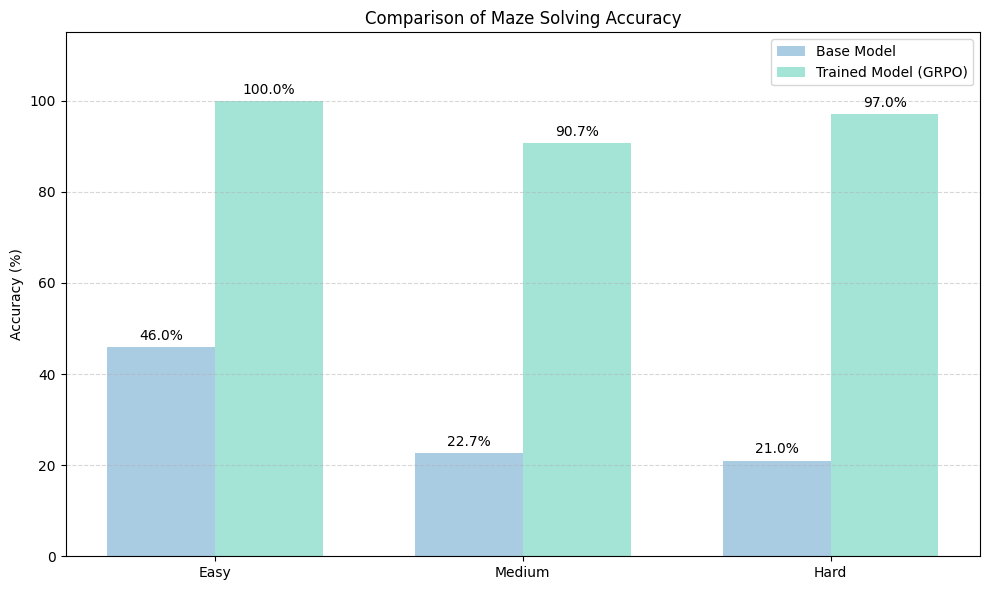

In [50]:
plot_benchmark(base_stats, trained_stats)